In [3]:
import os
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch
import collections
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import DataLoader
import torch.optim as optim
from torchsummary import summary
from torch.autograd import Variable
from PIL import Image

In [139]:
input_img_dir = './apple2orange/'

_img_list_trainA = [input_img_dir+'trainA/'+item for item in os.listdir(input_img_dir+'trainA/')]
_img_list_trainB = [input_img_dir+'trainB/'+item for item in os.listdir(input_img_dir+'trainB/')]
_img_list_testA = [input_img_dir+'testA/'+item for item in os.listdir(input_img_dir+'testA/')]
_img_list_testB = [input_img_dir+'testB/'+item for item in os.listdir(input_img_dir+'testB/')]

img_list_trainA = []
for item in tqdm(_img_list_trainA):
  tempimg = np.asarray(Image.open(item, ))
  img_list_trainA.append(tempimg)
    
    
img_list_trainB = []
for item in tqdm(_img_list_trainB):
  tempimg = np.asarray(Image.open(item, ))
  img_list_trainB.append(tempimg)
    
    
img_list_testA = []
for item in tqdm(_img_list_testA):
  tempimg = np.asarray(Image.open(item, ))
  img_list_testA.append(tempimg)

img_list_testB = []
for item in tqdm(_img_list_testB):
  tempimg = np.asarray(Image.open(item, ))
  img_list_testB.append(tempimg)    
    
    


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [145]:
trainA=np.stack(img_list_trainA)/255
trainB=np.stack(img_list_trainB)/255

testA=np.stack(img_list_testA)/255
testB=np.stack(img_list_testB)/255



#trainA=trainA.reshape(trainA.shape[0],3,256,256)
#trainB=trainB.reshape(trainB.shape[0],3,256,256)

#testA=testA.reshape(testA.shape[0],3,256,256)
#testB=testB.reshape(testB.shape[0],3,256,256)


trainA=trainA.transpose(0,3,2,1)
trainB=trainB.transpose(0,3,2,1)

testA=testA.transpose(0,3,2,1)
testB=testB.transpose(0,3,2,1)

In [6]:
class generator_unet(nn.Module):
    def __init__(self
                , input_filters
                , output_filters
                , input_filters_up
                , output_filters_up
                , f_size=4
                ):
        super(generator_unet, self).__init__()
        
        
        self.f_size=f_size
        self.input_filters=input_filters
        self.output_filters=output_filters
        self.input_filters_up=input_filters_up
        self.output_filters_up=output_filters_up
    
        #sequential이랑 moduledict 같이 사용 불가?? 
        self.downsample=nn.Sequential()
        self.dict_down_conv=nn.ModuleDict()
        self.dict_down_norm=nn.ModuleDict()
        self.dict_down_relu=nn.ModuleDict()
        self.dict_up_conv=nn.ModuleDict()
        self.dict_up_norm=nn.ModuleDict()
        self.dict_up_relu=nn.ModuleDict()
        self.dict_up_upsample=nn.ModuleDict()
        self.n_layers=len(input_filters)
        
        
        for i in range(self.n_layers):
            
                
            conv2d=nn.Conv2d(self.input_filters[i]
                                                     ,self.output_filters[i]
                                                     ,kernel_size=self.f_size
                                                     ,stride=2
                                                     ,padding=1
                                                     )
            
            
            norm=nn.InstanceNorm2d(self.output_filters[i])
            relu=nn.ReLU()
            self.dict_down_conv['Layer {}'.format(i)]=conv2d
            self.dict_down_norm['Layer {}'.format(i)]=norm
            self.dict_down_relu['Layer {}'.format(i)]=relu
            
        for i in range(self.n_layers):
            
            
            upsample=nn.Upsample(scale_factor=2)
         
            conv2d=nn.Conv2d(self.input_filters_up[i]
                                                     ,self.output_filters_up[i]
                                                     ,kernel_size=5
                                                     ,stride=1
                                                     ,padding=2
                                                     )
            
            
            norm=nn.InstanceNorm2d(self.input_filters[self.n_layers-i-1])
            relu=nn.ReLU()
            self.dict_up_upsample['Layer {}'.format(i)]=upsample
            self.dict_up_conv['Layer {}'.format(i)]=conv2d
            self.dict_up_norm['Layer {}'.format(i)]=norm
            self.dict_up_relu['Layer {}'.format(i)]=relu    
  
            
            
       # self.downsample.add_module('Layer {} instnorm'.format(i),nn.InstanceNorm2d(self.output_filters[i]))
       # self.downsample.add_module('Layer {} relu'.format(i),nn.ReLU())
            
            
    def forward(self, x):
        down_output = {}
        
        for i in range(self.n_layers):
            down_conv=self.dict_down_conv['Layer {}'.format(i)]
            down_norm=self.dict_down_norm['Layer {}'.format(i)]
            down_relu=self.dict_down_relu['Layer {}'.format(i)]
            x=down_conv(x)
            x=down_norm(x)
            x=down_relu(x)
            
            down_output[i]=x
            
        for i in range(self.n_layers):
           
            up_upsample=self.dict_up_upsample['Layer {}'.format(i)]
            up_conv=self.dict_up_conv['Layer {}'.format(i)]
            up_norm=self.dict_up_norm['Layer {}'.format(i)]
            up_relu=self.dict_up_relu['Layer {}'.format(i)]
            
            x=up_upsample(x)
            x=up_conv(x)
            x=up_norm(x)
            x=up_relu(x)
            if i<3:
                x = torch.cat([x, down_output[self.n_layers-i-2]], dim=1)    
           
        return x
        

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [10]:
gener=generator_unet(input_filters=[3,32,64,128], output_filters=[32,64,128,256],input_filters_up=[256,256,128,64],output_filters_up=[128,64,32,3])
gener=gener.to(device)

In [13]:
summary(gener,(3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
              ReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          32,832
    InstanceNorm2d-5           [-1, 64, 64, 64]               0
              ReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         131,200
    InstanceNorm2d-8          [-1, 128, 32, 32]               0
              ReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         524,544
   InstanceNorm2d-11          [-1, 256, 16, 16]               0
             ReLU-12          [-1, 256, 16, 16]               0
         Upsample-13          [-1, 256, 32, 32]               0
           Conv2d-14          [-1, 128,

In [31]:
class discriminator(nn.Module):
    def __init__(self
        , input_filters
        , output_filters
        , stride
        , padding
        , norm=True
        ):
        super(discriminator, self).__init__()
        
        self.input_filters=input_filters
        self.output_filters=output_filters
        self.name = 'discriminator'
        self.stride=stride
        self.padding=padding
        self.conv4 = nn.Sequential()
        
        self.n_layers=len(input_filters)
        
        
        for i in range(self.n_layers):
            
            self.conv4.add_module('Layer {} Conv2d'.format(i),
                            nn.Conv2d(self.input_filters[i]
                                    , self.output_filters[i]
                                    , kernel_size = 4
                                    , stride = self.stride[i]
                                    , padding = self.padding[i]
                                    ))
           
            self.conv4.add_module('Layer {} Instnorm'.format(i), nn.InstanceNorm2d(self.output_filters[i]))
            self.conv4.add_module('Layer {} LeakyReLU'.format(i), nn.LeakyReLU(0.2))
            
            if i==self.n_layers-1:
                self.conv4.add_module('Layer {} Conv2d'.format(i),
                            nn.Conv2d(self.input_filters[i]
                                    , self.output_filters[i]
                                    , kernel_size = 5
                                    , stride = self.stride[i]
                                    , padding = self.padding[i]
                                    ))


    def forward(self, x):
        x = self.conv4(x)
      
        
        return x

In [32]:
discrim=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
discrim=discrim.to(device)

In [33]:
summary(discrim,(3,256,256))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]           1,568
    InstanceNorm2d-2         [-1, 32, 128, 128]               0
         LeakyReLU-3         [-1, 32, 128, 128]               0
            Conv2d-4           [-1, 64, 64, 64]          32,832
    InstanceNorm2d-5           [-1, 64, 64, 64]               0
         LeakyReLU-6           [-1, 64, 64, 64]               0
            Conv2d-7          [-1, 128, 32, 32]         131,200
    InstanceNorm2d-8          [-1, 128, 32, 32]               0
         LeakyReLU-9          [-1, 128, 32, 32]               0
           Conv2d-10          [-1, 256, 16, 16]         524,544
   InstanceNorm2d-11          [-1, 256, 16, 16]               0
        LeakyReLU-12          [-1, 256, 16, 16]               0
           Conv2d-13            [-1, 1, 16, 16]           6,401
   InstanceNorm2d-14            [-1, 1,

In [34]:
optimizer_discrim=optim.Adam(discrim.parameters(), lr=discriminator_learning_rate)
criterion_discrim=nn.MSELoss().to(device)

optimizer_gener=optim.Adam(gener.parameters(), lr=generator_learning_rate)
criterion_gener=nn.MSELoss().to(device)


NameError: name 'discriminator_learning_rate' is not defined

In [146]:
d_A=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
d_A=d_A.to(device)
d_B=discriminator(input_filters=[3,32,64,128,256], output_filters=[32,64,128,256,1],stride=[2,2,2,2,1],padding=[1,1,1,1,2])
d_B=d_B.to(device)

g_AB=generator_unet(input_filters=[3,32,64,128], output_filters=[32,64,128,256],input_filters_up=[256,256,128,64],output_filters_up=[128,64,32,3])
g_AB=g_AB.to(device)

g_BA=generator_unet(input_filters=[3,32,64,128], output_filters=[32,64,128,256],input_filters_up=[256,256,128,64],output_filters_up=[128,64,32,3])
g_BA=g_BA.to(device)

optimizer_d_A=optim.Adam(d_A.parameters(), lr=0.5)
criterion_d_A=nn.MSELoss().to(device)

optimizer_d_B=optim.Adam(d_B.parameters(), lr=0.5)
criterion_d_B=nn.MSELoss().to(device)

optimizer_gAB=optim.Adam(g_AB.parameters(), lr=0.0002)
criterion_gAB_1=nn.MSELoss().to(device)
criterion_gAB_2=nn.L1Loss().to(device)
criterion_gAB_3=nn.L1Loss().to(device)

optimizer_gBA=optim.Adam(g_BA.parameters(), lr=0.5)
criterion_gBA_1=nn.MSELoss().to(device)
criterion_gBA_2=nn.L1Loss().to(device)
criterion_gBA_3=nn.L1Loss().to(device)

In [38]:
g_AB=generator_unet(input_filters=[3,32,64,128], output_filters=[32,64,128,256],input_filters_up=[256,256,128,64],output_filters_up=[128,64,32,3])
g_AB=g_AB.to(device)
g_BA=generator_unet(input_filters=[3,32,64,128], output_filters=[32,64,128,256],input_filters_up=[256,256,128,64],output_filters_up=[128,64,32,3])
g_BA=g_BA.to(device)

In [183]:
best_loss=10000
total_loss=0
be_discrim=0
be_gener=0
batch_size=1


for epoch in range(100):
    loop=0
    for a_batch, b_batch in tqdm(zip(DataLoader(trainA,batch_size,shuffle=True)
                                  ,DataLoader(trainB,batch_size,shuffle=True))):
        a_batch=a_batch.to(device=device, dtype=torch.float)
        b_batch=b_batch.to(device=device, dtype=torch.float)                             
        
        real=Variable(torch.ones(16,16)).float().to(device)            
        fake=Variable(torch.zeros(16,16)).float().to(device)            
    
        fake_B = g_AB(a_batch)
        fake_A = g_BA(b_batch)  
                                     
        labels_valid_A=d_A(a_batch)
        labels_fake_A=d_A(fake_A)                             
        labels_valid_B=d_B(a_batch)
        labels_fake_B=d_B(fake_B)  
                                     
                                     
        discriminator_loss_real_A=criterion_d_A(labels_valid_A,real)
        discriminator_loss_fake_A=criterion_d_A(labels_fake_A,fake)
        dA_loss=0.5*(discriminator_loss_real_A+discriminator_loss_fake_A)                    
        discriminator_loss_real_B=criterion_d_B(labels_valid_B,real)
        discriminator_loss_fake_B=criterion_d_B(labels_fake_B,fake)
        dB_loss=0.5*(discriminator_loss_real_B+discriminator_loss_fake_B)              

        discriminator_loss=0.5*(dA_loss+dB_loss)
    
    
        optimizer_d_A.zero_grad()
        optimizer_d_B.zero_grad()                             
        discriminator_loss.backward()
        optimizer_d_A.step()
        optimizer_d_B.step() 
                       
        ###########GEngnerator loss
        fake_A=g_BA(b_batch)      
        fake_B=g_AB(a_batch)  
        valid_A=d_A(fake_A)
        valid_B=d_B(fake_B)   
        reconstr_A=g_BA(fake_B)
        reconstr_B=g_AB(fake_A)
        img_A_id=g_BA(a_batch)
        img_B_id=g_AB(b_batch)                              
                                     
      
        loss1_A=criterion_gAB_1(valid_A,real)
        loss1_B=criterion_gBA_1(valid_B,real)
        loss1=0.5*(loss1_A+loss1_B)
          
        loss2_A=criterion_gAB_2(reconstr_A,a_batch)                             
        loss2_B=criterion_gBA_2(reconstr_B,b_batch)   
        loss2=0.5*(loss2_A+loss2_B)                             
                                     
        loss3_A=criterion_gAB_3(img_A_id,a_batch)                             
        loss3_B=criterion_gBA_3(img_B_id,b_batch)   
        loss3=0.5*(loss3_A+loss3_B)                              
                                   
        total_gen_loss=(loss1+loss2+loss3)/3                        
                                     
        optimizer_gAB.zero_grad()
        optimizer_gBA.zero_grad()                             
        total_gen_loss.backward()
        optimizer_gAB.step()
        optimizer_gBA.step()                              
        
        loop=loop+1
        if loop%10==0:                           
            print("%d: Discriminator Loss=%.6f, Generator Loss=%.6f" % (epoch, discriminator_loss.item(), total_gen_loss.item()))

C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:11: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  # This is added back by InteractiveShellApp.init_path()


0: Discriminator Loss=0.412845, Generator Loss=0.374177
0: Discriminator Loss=0.438661, Generator Loss=0.339775
0: Discriminator Loss=0.413460, Generator Loss=0.290931
0: Discriminator Loss=0.403949, Generator Loss=0.346927
0: Discriminator Loss=0.412664, Generator Loss=0.368488
0: Discriminator Loss=0.437626, Generator Loss=0.361303
0: Discriminator Loss=0.425170, Generator Loss=0.311330
0: Discriminator Loss=0.416397, Generator Loss=0.299743
0: Discriminator Loss=0.417024, Generator Loss=0.342436
0: Discriminator Loss=0.418304, Generator Loss=0.347747
0: Discriminator Loss=0.435833, Generator Loss=0.309605
0: Discriminator Loss=0.409630, Generator Loss=0.346420
0: Discriminator Loss=0.425887, Generator Loss=0.392801
0: Discriminator Loss=0.419273, Generator Loss=0.317366
0: Discriminator Loss=0.410418, Generator Loss=0.339251
0: Discriminator Loss=0.423306, Generator Loss=0.355823
0: Discriminator Loss=0.413439, Generator Loss=0.324762
0: Discriminator Loss=0.427643, Generator Loss=0

1: Discriminator Loss=0.410194, Generator Loss=0.275932
1: Discriminator Loss=0.411177, Generator Loss=0.331993
1: Discriminator Loss=0.413948, Generator Loss=0.353472
1: Discriminator Loss=0.400296, Generator Loss=0.393924
1: Discriminator Loss=0.441061, Generator Loss=0.365543
1: Discriminator Loss=0.401424, Generator Loss=0.345368
1: Discriminator Loss=0.392202, Generator Loss=0.320539
1: Discriminator Loss=0.424991, Generator Loss=0.334371
1: Discriminator Loss=0.420482, Generator Loss=0.347735
1: Discriminator Loss=0.424050, Generator Loss=0.290424
1: Discriminator Loss=0.419026, Generator Loss=0.306556
1: Discriminator Loss=0.413125, Generator Loss=0.350184
1: Discriminator Loss=0.402591, Generator Loss=0.373733
1: Discriminator Loss=0.425029, Generator Loss=0.413594
1: Discriminator Loss=0.410284, Generator Loss=0.286190
1: Discriminator Loss=0.409959, Generator Loss=0.333631
1: Discriminator Loss=0.424859, Generator Loss=0.314981
1: Discriminator Loss=0.408921, Generator Loss=0

2: Discriminator Loss=0.423440, Generator Loss=0.373745
2: Discriminator Loss=0.415205, Generator Loss=0.326488
2: Discriminator Loss=0.418978, Generator Loss=0.303398
2: Discriminator Loss=0.409640, Generator Loss=0.301796
2: Discriminator Loss=0.434784, Generator Loss=0.358232
2: Discriminator Loss=0.426578, Generator Loss=0.383509
2: Discriminator Loss=0.415706, Generator Loss=0.374135
2: Discriminator Loss=0.416255, Generator Loss=0.295489
2: Discriminator Loss=0.428839, Generator Loss=0.346816
2: Discriminator Loss=0.418462, Generator Loss=0.284130
2: Discriminator Loss=0.411818, Generator Loss=0.306379
2: Discriminator Loss=0.409059, Generator Loss=0.340392
2: Discriminator Loss=0.405440, Generator Loss=0.286684
2: Discriminator Loss=0.452558, Generator Loss=0.473442
2: Discriminator Loss=0.417221, Generator Loss=0.326305
2: Discriminator Loss=0.407665, Generator Loss=0.309250
2: Discriminator Loss=0.401740, Generator Loss=0.311663
2: Discriminator Loss=0.439268, Generator Loss=0

3: Discriminator Loss=0.426843, Generator Loss=0.324432
3: Discriminator Loss=0.407976, Generator Loss=0.300890
3: Discriminator Loss=0.391237, Generator Loss=0.331586
3: Discriminator Loss=0.429492, Generator Loss=0.332571
3: Discriminator Loss=0.395212, Generator Loss=0.320110
3: Discriminator Loss=0.421172, Generator Loss=0.306408
3: Discriminator Loss=0.415560, Generator Loss=0.298042
3: Discriminator Loss=0.386301, Generator Loss=0.306911
3: Discriminator Loss=0.417806, Generator Loss=0.318533
3: Discriminator Loss=0.410578, Generator Loss=0.412840
3: Discriminator Loss=0.417986, Generator Loss=0.306594
3: Discriminator Loss=0.407902, Generator Loss=0.361467
3: Discriminator Loss=0.414813, Generator Loss=0.291776
3: Discriminator Loss=0.403835, Generator Loss=0.329639
3: Discriminator Loss=0.404524, Generator Loss=0.300309
3: Discriminator Loss=0.399475, Generator Loss=0.309829
3: Discriminator Loss=0.433141, Generator Loss=0.340588
3: Discriminator Loss=0.404206, Generator Loss=0

4: Discriminator Loss=0.402634, Generator Loss=0.316858
4: Discriminator Loss=0.419695, Generator Loss=0.289784
4: Discriminator Loss=0.413698, Generator Loss=0.324026
4: Discriminator Loss=0.410594, Generator Loss=0.307271
4: Discriminator Loss=0.401772, Generator Loss=0.305820
4: Discriminator Loss=0.395213, Generator Loss=0.358231
4: Discriminator Loss=0.419726, Generator Loss=0.319896
4: Discriminator Loss=0.398411, Generator Loss=0.300975
4: Discriminator Loss=0.397879, Generator Loss=0.327268
4: Discriminator Loss=0.387181, Generator Loss=0.323847
4: Discriminator Loss=0.398875, Generator Loss=0.337608
4: Discriminator Loss=0.403005, Generator Loss=0.325509
4: Discriminator Loss=0.386231, Generator Loss=0.304693
4: Discriminator Loss=0.423039, Generator Loss=0.305574
4: Discriminator Loss=0.410277, Generator Loss=0.312976
4: Discriminator Loss=0.405068, Generator Loss=0.284555
4: Discriminator Loss=0.418231, Generator Loss=0.289715
4: Discriminator Loss=0.416232, Generator Loss=0

KeyboardInterrupt: 

In [57]:
for a_batch, b_batch in tqdm(zip(DataLoader(trainA,batch_size,shuffle=True)
                                  ,DataLoader(trainB,batch_size,shuffle=True))):
    pass

C:\Users\Richard Kim\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [129]:

trainA=trainA.transpose(0,2,3,1)
trainB=trainB.transpose(0,2,3,1)

testA=testA.transpose(0,2,3,1)
testB=testB.transpose(0,2,3,1)


In [130]:
trainA.shape

(995, 3, 256, 256)

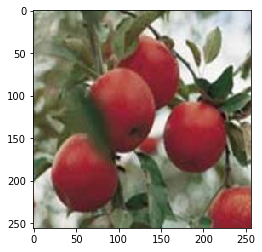

In [180]:
plt.imshow(testA.transpose(0,3,2,1)[15])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


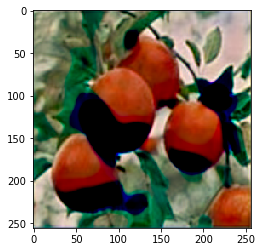

In [182]:
plt.imshow(g_AB(torch.tensor(testA[[15]]).float().to(device)).cpu().detach().numpy().transpose(0,3,2,1).squeeze(0))